In [2]:
import torch

model_path = "./models/baseline_balanced.pth"  # Change to "proposed_model.pth" to check both files

checkpoint = torch.load(model_path, map_location="cpu")
print("Keys in checkpoint:", checkpoint.keys())

if "state_dict" in checkpoint:
    print("Model contains state_dict with layers:", checkpoint["state_dict"].keys())
else:
    print("Model is saved as a full model (not state_dict).")


Keys in checkpoint: odict_keys([])
Model is saved as a full model (not state_dict).


C:\Users\Angelika Vergara\AppData\Local\Temp\ipykernel_22684\2532710176.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=

c:\Users\Angelika Vergara\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 229s 267ms/step - accuracy: 0.6710 - loss: 0.5957 - val_accuracy: 0.0471 - val_loss: 0.7602
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 223s 265ms/step - accuracy: 0.6543 - loss: 0.5977 - val_accuracy: 0.8408 - val_loss: 0.3405
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 231s 274ms/step - accuracy: 0.8838 - loss: 0.2902 - val_accuracy: 0.8626 - val_loss: 0.3315
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 247s 293ms/step - accuracy: 0.8940 - loss: 0.2672 - val_accuracy: 0.8963 - val_loss: 0.2527
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 247s 292ms/step - accuracy: 0.9000 - loss: 0.2525 - val_accuracy: 0.8823 - val_loss: 0.2535
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 39s 21ms/step

Classification Report:
              precision    recall  f1-score   support

   Non-Toxic       0.84      0.65      0.73     29276
       Toxic       0.71      0.87      0.79     29276

    accuracy                           0.76     58552
   macro avg       0.77      0.76      0.76     58552
weig

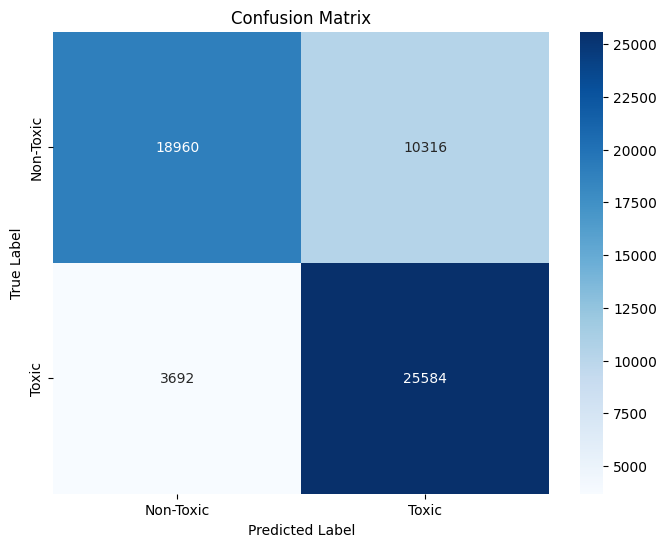

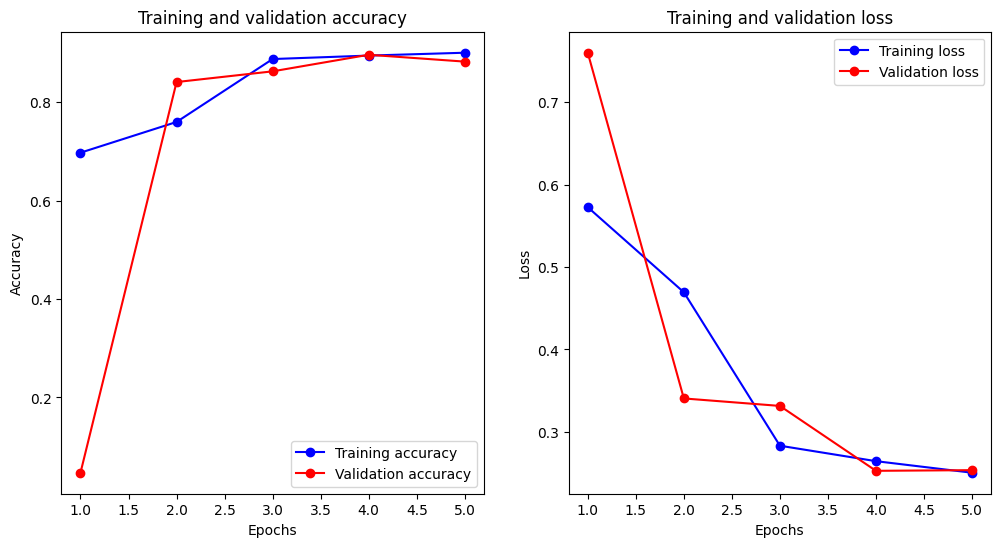

In [1]:
import numpy as np
import pandas as pd
import re
import spacy
import pickle
import torch
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

# Load SpaCy model (en_core_web_md has 300d vectors)
nlp = spacy.load("en_core_web_md", disable=["parser", "ner"])

def load_datasets():
    train_df = pd.read_csv('train.csv')
    test_df = pd.read_csv('test.csv')
    train_df = train_df[['text', 'label']]
    test_df = test_df[['text', 'label']]
    return train_df, test_df

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+|@\w+|#", "", text)  
    text = re.sub(r"[^a-zA-Z\s]", "", text)  
    text = re.sub(r"\s+", " ", text).strip()  
    
    contractions = {
        "can't": "cannot", "won't": "will not", "n't": " not", "'re": " are", "'s": " is",
        "'d": " would", "'ll": " will", "'t": " not", "'ve": " have", "'m": " am"
    }
    for key, val in contractions.items():
        text = text.replace(key, val)
    
    return text

def preprocess_texts(texts):
    cleaned_texts = [clean_text(text) for text in texts]
    
    processed_texts = []
    for doc in nlp.pipe(cleaned_texts, batch_size=500):
        processed_texts.append(" ".join([token.lemma_ for token in doc if not token.is_stop]))
    
    return processed_texts

def prepare_model_input(train_df, test_df):
    train_df['processed_text'] = preprocess_texts(train_df['text'].tolist())
    test_df['processed_text'] = preprocess_texts(test_df['text'].tolist())
    
    unique_words = set(word for text in train_df['processed_text'] for word in text.split())
    tokenizer = {word: i+1 for i, word in enumerate(unique_words)}
    
    train_sequences = [[tokenizer.get(word, 0) for word in text.split()] for text in train_df['processed_text']]
    test_sequences = [[tokenizer.get(word, 0) for word in text.split()] for text in test_df['processed_text']]
    
    X_train = pad_sequences(train_sequences, maxlen=128, padding='post', truncating='post')
    X_test = pad_sequences(test_sequences, maxlen=128, padding='post', truncating='post')
    
    vocab_size = len(tokenizer) + 1
    embedding_matrix = np.zeros((vocab_size, 300))
    for word, i in tokenizer.items():
        embedding_matrix[i] = nlp(word).vector if word in nlp.vocab else np.zeros(300)
    
    return X_train, X_test, train_df['label'], test_df['label'], tokenizer, embedding_matrix, vocab_size

def build_model(vocab_size, embed_dim=300, embedding_matrix=None):
    model = Sequential([
        Embedding(vocab_size, embed_dim, input_length=128, 
                  weights=[embedding_matrix] if embedding_matrix is not None else None, trainable=False),
        SpatialDropout1D(0.3),
        LSTM(128, return_sequences=False, dropout=0.2, recurrent_dropout=0.2),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

def plot_confusion_matrix(y_true, y_pred, class_names, title=None):
    """Plots a confusion matrix as a heatmap."""
    cm = confusion_matrix(y_true, y_pred)
    if title is None:
        title = "Confusion Matrix"

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

def plot_training_history(history):
    """Plots training accuracy and loss per epoch."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

def main():
    train_df, test_df = load_datasets()
    X_train, X_test, y_train, y_test, tokenizer, embedding_matrix, vocab_size = prepare_model_input(train_df, test_df)
    
    model = build_model(vocab_size, embed_dim=300, embedding_matrix=embedding_matrix)
    
    history = model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=5,
        batch_size=128,
        verbose=1
    )
        
    # Convert TensorFlow/Keras model to PyTorch and save
    class SimpleModel(torch.nn.Module):
        def __init__(self, keras_model):
            super(SimpleModel, self).__init__()
            self.keras_model = keras_model

        def forward(self, x):
            # Keras expects a batch dimension, but PyTorch might not always provide it
            if len(x.shape) == 2:
                x = x.unsqueeze(0)  # Add batch dimension if missing
            x = self.keras_model(x).squeeze()  # Remove unnecessary dimensions
            return torch.sigmoid(torch.tensor(x))  # Ensure output is a sigmoid

    # Wrap the Keras model
    pytorch_model = SimpleModel(model)

    # Save the PyTorch model
    torch.save(pytorch_model.state_dict(), "baseline_balanced.pth")

    with open("tokenizer.pkl", "wb") as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs > 0.5).astype("int32")
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Non-Toxic', 'Toxic']))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    
    plot_confusion_matrix(y_test, y_pred, class_names=['Non-Toxic', 'Toxic'])

    plot_training_history(history)

if __name__ == "__main__":
    main()


In [3]:
import torch

# Save the model's state_dict
def save_model(model, path="baseline_balanced.pth"):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

# Load the model's state_dict
def load_model(model_class, path="baseline_balanced.pth", *args, **kwargs):
    model = model_class(*args, **kwargs)  # Initialize the model
    model.load_state_dict(torch.load(path))  # Load the saved state_dict
    model.eval()  # Set to evaluation mode
    print(f"Model loaded from {path}")
    return model

# Example usage:
if __name__ == "__main__":
    # Assuming `SimpleModel` is your LSTM model class
    class SimpleModel(torch.nn.Module):
        def __init__(self, input_dim=300, hidden_dim=128, output_dim=1):
            super(SimpleModel, self).__init__()
            self.lstm = torch.nn.LSTM(input_dim, hidden_dim, batch_first=True)
            self.fc = torch.nn.Linear(hidden_dim, output_dim)
            self.sigmoid = torch.nn.Sigmoid()

        def forward(self, x):
            lstm_out, _ = self.lstm(x)
            out = self.fc(lstm_out[:, -1])  # Use last time step's output
            return self.sigmoid(out)

    # Initialize and save the model
    input_dim = 300
    hidden_dim = 128
    output_dim = 1
    lstm_model = SimpleModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)

    # Save the model
    save_model(lstm_model)

    # Load the model
    loaded_model = load_model(SimpleModel, path="baseline_balanced.pth", input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)


Model saved to baseline_balanced.pth
Model loaded from baseline_balanced.pth


C:\Users\Angelika Vergara\AppData\Local\Temp\ipykernel_27860\69039247.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))  # Load th

In [2]:
from transformers import BertModel, BertTokenizer

# Load the pre-trained model
model = BertModel.from_pretrained('bert-base-uncased')

# Print the architecture
print(model)


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [4]:
import torch

# Load the saved state dict
state_dict = torch.load("baseline_balanced.pth", map_location=torch.device("cpu"))

# Resize the 'fc' layer weights and bias to match the new model's shape
state_dict["fc.weight"] = torch.nn.Parameter(torch.randn(3, 128))  # Adjust to (3, 128)
state_dict["fc.bias"] = torch.nn.Parameter(torch.randn(3))  # Adjust to (3,)

# Save the modified state dict
torch.save(state_dict, "models/baseline_balanced_fixed.pth")


C:\Users\Angelika Vergara\AppData\Local\Temp\ipykernel_5864\3241387792.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("baseline_balanced.pth", m